In [1]:
import time
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import networkx.algorithms.community as nxc
from networkx import edge_betweenness_centrality as betweenness
from edge_split import EdgeSplitter
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, recall_score

import random

# pip install python-louvain
from community import community_louvain as community_louvain
from community import generate_dendrogram as generate_dendrogram
from community import partition_at_level as partition_at_level

In [2]:
start_time = time.time()

# Portfolio Exam 2

## Story

As a data science service agency we were approached logistics depatment of by a company which runs an e-commerce plattform and wants to establish an order fulfillment network in europe.

We have been provided with a dataset sourced from networkrepository.com containing nodes and edges, where the nodes represent highway access points or intersections and the edges represent connecting highways. The dataset does not contain geographic information or city names.

We are to analyze and describe the stucture of the graph, identify central nodes and community of nodes, in order to:
- extract well connected regions in network
- find locations which would be suitable for fulfillment centers
- predict whether new roads will be built in the future between two points

Download link to data: https://networkrepository.com/road-euroroad.php

The networkrepository.com provides some public statistics about this graph network:
- Nodes: 1200
- Edges: 1400
- Density: 0.00205794
- Maximum degree: 10
- Minimum degree: 1
- Average degree: 2
- Assortativity: 0.126684
- Number of triangles: 96
- Avg. number of triangles: 0
- Max. Number of triangles: 2
- Average clustering coefficient: 0.0167316
- Fraction of closed triangles: 0.0338863
- Maxium k-core: 3
- Lower bound of Maximum Clique: 3

We will investigate the graph properties again in the explorative data analysis.

## Making Graph

In [3]:
# reading edgelist
G = nx.read_edgelist('road-euroroad.edges', create_using=nx.Graph(), nodetype=int)

## Displaying Graph

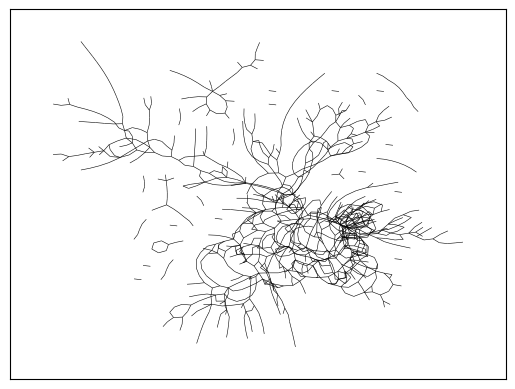

In [4]:
# plotting the graph
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx_edges(G, pos=pos, width=.4);

When plotting the road network graph, we can see there are densly connected areas and some losely connected areas as well as some unconnected components in the graph. The unconnected components will be islands where the highways can't connect directly to the mainland.

While we can summize that the most dense part of the graph is probably in Germany because it has the highest density of highways in europe, it should be noted that the drawing of the graph in this form does not correspond to the map of europe. 

For our purpose of our experiments we will be excluding the unconnected components by redefining the graph as the giant connected component.

## Giant Connected Component

Since certain measures require a connected graph, we are redifining the graph *G* to exclude all unconnected components, leaving us with the giant connected component.

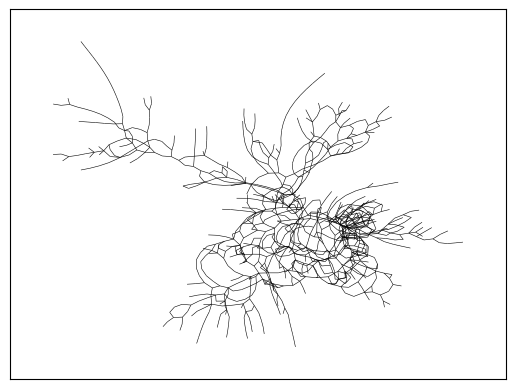

In [5]:
# extracting giant connect component
G = G.subgraph(max(nx.connected_components(G), key=len))

# plotting the giant connected component
nx.draw_networkx_edges(G, pos=pos, width=.4);

## Intial Analysis

In [6]:
# printing number of vertices/nodes and number of edges
G.order(), G.size()

(1039, 1305)

After redefining the graph *G* to the giant connected components, it contains 1039 nodes and 1305 edges.


### Investigate Neighborhood of node labeled 6

Most nodes in the network have a degree of two, so they are connected to two other nodes.

In [7]:
# creating a set of neighbors of node 6
set(nx.neighbors(G, n=6))

{7, 880}

The neighbors of the node labeled 6 are the nodes labeled 7 and 880.

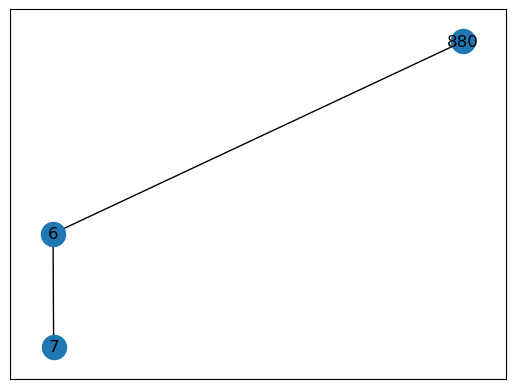

In [8]:
nx.draw_networkx(nx.ego_graph(G, n=6), pos=pos, with_labels=True)

The node labeled 6 represents most nodes within the network. We can relate this to the real world, because we know most nodes in a highway network are usually the access points and only few nodes are highway intersections.

Next we are going to take a look at a node with several connections.

### Investigate Neighborhood of node labeled 9

In [9]:
# creating a set of neighbors of node 9
set(nx.neighbors(G, n=9))

{8, 10, 537, 561, 1074}

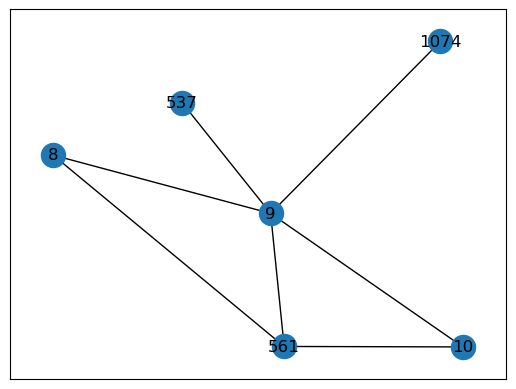

In [10]:
nx.draw_networkx(nx.ego_graph(G, n=9), pos=pos, with_labels=True)

The node labeled 9 has 5 neighboring nodes. This can interpreted to be an intersection of two highways, where a third highway originates or terminates.

Most nodes in the graph *G* have a degree of two or three, while only a few have degrees higher than that. In road network most nodes aren't intersections but highway access points on a route connecting big intersections.

## Graph Properties

In [11]:
def test_property_on_random_graph(G, measure_lambda, tries=10, min_frac_size=0, size_multiplier=1):
    """ Is able to produce random graphs with the same properties as G 
        or produce resized graphs with a specific fractional size of G.

    Args:
        G (graph): networkx standard graph
        measure_lambda (measure): the measure that is to be calculated for the random graphs
        tries (int, optional): Number of graphs that get generarte randomly. Defaults to 10.
        min_frac_size (int, optional): allowed minimum fractional size for R of G. Defaults to 0.
        size_multiplier (int, optional): multiplier to control the new size of R. Defaults to 1.

    Returns:
        float: result of measurement
    """
    sum_property=0
    count=0
    seed=0
    connected_graphs=0
    while True:
        seed=seed+1
        R=nx.gnm_random_graph(int(G.order()*size_multiplier), int(G.size()*size_multiplier), seed=seed)
        R_temp = R.subgraph(max(nx.connected_components(R), key=len))
        fractional_size = (R_temp.order() / G.order())
        if (fractional_size >= min_frac_size) or (nx.is_connected(R)):
            if not nx.is_connected(R):
                R = R.subgraph(max(nx.connected_components(R), key=len))
            measurement=measure_lambda(R)
            sum_property=sum_property+measurement
            count=count+1
            connected_graphs=connected_graphs+1
        if (connected_graphs>=tries):
            break
    print(sum_property, count)
    return sum_property/count

### Density

In [12]:
# calculating density of G
nx.density(G)

0.0024200682069798105

In [13]:
# calculating density of R
test_property_on_random_graph(G, lambda H: nx.density(H))

0.02988605669234328 10


0.002988605669234328

Density
- G: 0.0024
- R: 0.0029

The density describes the ratio of existing connections to total number of possible connections in a graph and is based on the number of edges and nodes. When we randomly generate graphs with the same number of nodes and edges, their density will be very similar to that of *G*.

Low density is explained by geography and how roads are planned and built: usually to the next neighbor and then beyond to an important hub.

The density in the example of this road network is low compared to other graph structures like that of social networks.

In a road network the nodes are fixed in a two dimensional space. In this space only a few nodes are topological neighbors, while this would be different in a high dimensional space.

The low density makes it almost impossible to generate a random graph without unconnected components. This required adapting the function 'test_property_on_random_graph' to deal with this. The function originally produced graphs until one without unconnected components was generated. 

This works fine when the density is similar to that of a social network but doesn't work when the density is much lower than that like that ofdd a road network.

For this reason we generate an oversized graph *R*, from which we extract the largest connected component, which in turn gives us a graph comparable to *G*. 

This change means that the size of the generated graph is not exactly the same size as *G* but was observed to be within +/- 1% of the size of *G* which is close enough for our purposes.

### Diameter

In [14]:
# diameter (longest shortest path) of G 
nx.diameter(G)

62

In [15]:
# diameter (longest shortest path) of R 
test_property_on_random_graph(
    G,
    lambda R: nx.diameter(R),
    min_frac_size=0.99, size_multiplier=1/0.9)

169 10


16.9

Diameter
- G: 62
- R: 16.9

The diameter in a graph describes the longest shortest path between two nodes. In a road network those would be the two cities furthest apart that can still be directly connected.

*G* has a diameter aprox. 4 times larger than *R*.

Probably there are regions in the network which are less well connected than they would be in a random graph or that some regions of the network have lower connectivity.

The random graphs are essentialy created in an infinite dimensional space, where any node can be connected to any other node without issues, whilst this is not possible in a road network bound to two dimensions.

### Average Shortest Path Length

In [16]:
# calculating average shortest path length of G
nx.average_shortest_path_length(G)

18.39514614059391

In [17]:
# calculating average shortest path length of R
test_property_on_random_graph(
    G,
    lambda R: nx.average_shortest_path_length(R))

72.39268424693313 10


7.2392684246933126

Average Shortest Path Length
- G: 18.4
- R: 7.2

The average shortest path length of *G* is aprox. 2.5x larger than that of *R*. This is due to the tendency of randomly generated graphs to produce cross links between nodes that won't exist in a road network, where the most common number of connections to a node is two. 

This explains why the shortest average path length in random graphs with the same properties is smaller. 

## Calculating Betweenness and Closeness Centralities

In [18]:
# empty dataframe for results
df_res = pd.DataFrame()

# making list of nodes
nodes = []
for node in G.degree:
    nodes.append(node[0])
df_res['node'] = nodes

# dict of stength per node
degrees = {}
for node, strength in G.degree:
    # printing degrees per node
    # print(node), print(strength)
    degrees[node] = strength

In [19]:
# adding degrees to dataframe
df_degrees = pd.DataFrame(degrees, index=[0]).T
df_degrees = df_degrees.reset_index()

df_res = pd.concat([df_res, df_degrees], axis=1)

df_res.columns = ['node', 'index', 'degrees']

df_res = df_res.drop(['index'], axis=1)


In [20]:
# betweenness centrality measures the importance of nodes in connectivity of the network
betweenness_cent = nx.betweenness_centrality(G)

df_centralities = pd.DataFrame(betweenness_cent, index=[0]).T
df_centralities = df_centralities.reset_index()
df_centralities = df_centralities.drop(['index'], axis=1)

df_res = pd.concat([df_res, df_centralities], axis=1)
df_res.columns = ['node', 'degrees', 'betweenness_cent']

In [21]:
# closeness
closeness_cent = nx.closeness_centrality(G)

df_closeness = pd.DataFrame(closeness_cent, index=[0]).T
df_closeness

df_closeness = df_closeness.reset_index()
df_closeness = df_closeness.drop(['index'], axis=1)

df_res = pd.concat([df_res, df_closeness], axis=1)
df_res.columns = ['node', 'degrees', 'betweenness_cent', 'closeness_cent']

In [22]:
# calculating relative measures
df_res['degrees_r'] = df_res.degrees / len(G)
df_res['betweenness_cent_r'] = df_res.betweenness_cent / len(G)
df_res['closeness_cent_r'] = df_res.closeness_cent / len(G)

# reordering dataframe
df_res.columns = [
    'node', 'degrees', 'degrees_r', 'betweenness_cent',
    'betweenness_cent_r', 'closeness_cent', 'closeness_cent_r']

### Nodes with highest relative betweenness centrality

In [23]:
# filtering for nodes with the highest relative betweenness centrality
df_res.sort_values('betweenness_cent_r', ascending=False).head(5)

,node,degrees,degrees_r,betweenness_cent,betweenness_cent_r,closeness_cent,closeness_cent_r
448,284,10,0.271419,0.082473,0.009625,0.000261,0.000079
1,7,8,0.184288,0.078506,0.007700,0.000177,0.000076
168,107,8,0.055258,0.067763,0.007700,0.000053,0.000065
53,39,8,0.011742,0.065892,0.007700,0.000011,0.000063
158,137,8,0.079181,0.075645,0.007700,0.000076,0.000073


In [24]:
# filtering for nodes with the highest absolute betweenness centrality
df_res.sort_values('betweenness_cent', ascending=False).head(5)

,node,degrees,degrees_r,betweenness_cent,betweenness_cent_r,closeness_cent,closeness_cent_r
376,401,7,0.204413,0.086862,0.006737,0.000197,0.000084
593,402,4,0.274329,0.086760,0.003850,0.000264,0.000084
408,403,4,0.221395,0.085201,0.003850,0.000213,0.000082
621,432,4,0.144372,0.083723,0.003850,0.000139,0.000081
595,1019,3,0.057684,0.083662,0.002887,0.000056,0.000081


The nodes with the highest relative betweenness centrality gives are generally interesting nodes. These nodes are:
- nodes that have many shortest paths running through them
- important highway intersection, which are critical hubs to enable efficient travel accross the road network
- bottle necks because a failure in any of these would lead to chaos in the system

Due to their position these node are important connections to many other nodes. This makes them suitable locations for logistics hubs.

### Nodes with highest relative closeness centrality

In [25]:
# finding nodes with short average distances to the rest of the network
# filtering for nodes with highest relative betweeness centrality 
df_res.sort_values('closeness_cent_r', ascending=False).head(5)

,node,degrees,degrees_r,betweenness_cent,betweenness_cent_r,closeness_cent,closeness_cent_r
376,401,7,0.204413,0.086862,0.006737,0.000197,0.000084
593,402,4,0.274329,0.086760,0.003850,0.000264,0.000084
408,403,4,0.221395,0.085201,0.003850,0.000213,0.000082
621,432,4,0.144372,0.083723,0.003850,0.000139,0.000081
595,1019,3,0.057684,0.083662,0.002887,0.000056,0.000081


In [26]:
# finding nodes with short average distances to the rest of the network
# filtering for nodes with highest relative betweeness centrality 
df_res.sort_values('closeness_cent', ascending=False).head(5)

,node,degrees,degrees_r,betweenness_cent,betweenness_cent_r,closeness_cent,closeness_cent_r
593,402,4,0.274329,0.086760,0.003850,0.000264,0.000084
448,284,10,0.271419,0.082473,0.009625,0.000261,0.000079
446,277,5,0.249643,0.080697,0.004812,0.000240,0.000078
7,453,5,0.223648,0.080665,0.004812,0.000215,0.000078
596,452,2,0.222695,0.083327,0.001925,0.000214,0.000080


The nodes with a low closeness centrality have a long average distance to the rest of the network. This will be nodes either at the fringes of the road network or nodes that despite the central position are badly connected to the rest of the network.

While the nodes with a high relative closeness have a short average distance to rest of the network, which makes them central points and also well suited as the sites for logistics hubs.

Across all nodes the node labeled 401 stand out as it has both the highest absolute betweenness centrality and the highest relative closeness centrality

## Clustering
### Transitivity / Global Clustering Coefficient

In [27]:
# calculating transitivity for G
nx.transitivity(G)

0.03525523319867793

In [28]:
# calculating transitivity for R
test_property_on_random_graph(G, lambda R: nx.transitivity(R))

0.024701874724525022 10


0.002470187472452502

Transistivity
- G: 0.0352
- R: 0.0024

Transitivity is a measure of how well connected a graph is, this calculated as the fraction of closed triplets across all possible triplets and measures the tendency of nodes to form tightly knit communities.

The transitivity of *G* is aprox. 15x larger than that of *R*.

This means that the road network is much more strongly connected than would be expected by chance. 

In other words the road network has a structure that increases the probability of neighbors being connected by 15 times compared to randomly generated graphs with the same property. 

This will likely because the road network has been planned and designed to have a high level of connectivity.

### Average Clustering Coefficient

In [29]:
# calculating clusering coefficient for G
nx.average_clustering(G)

0.018905541042210917

In [30]:
# calculating clusering coefficient for R
test_property_on_random_graph(G, lambda R: nx.average_clustering(R))

0.017722329550293365 10


0.0017722329550293365

Average Clustering Coefficient
- G: 0.0189
- R: 0.0017

The average clustering coefficient is calculated by measuring the number of triplets in a graph.

The average clustering coefficient of *G* is aprox. 10x higher than that of *R*. This implies that the roads are strongly interconnected and thus the network is easy to navigate and well-connected.

The high average local clustering coefficient in the road network graph as compared to random graph with similar properties is likely due to the design and construction of the roads, where there is an incentive to connect roads between three cities in the same region, creating a "triplet" and resulting in a highly interconnected network. This incentive doesn't play a role in randomly generated graphs.

## Degrees

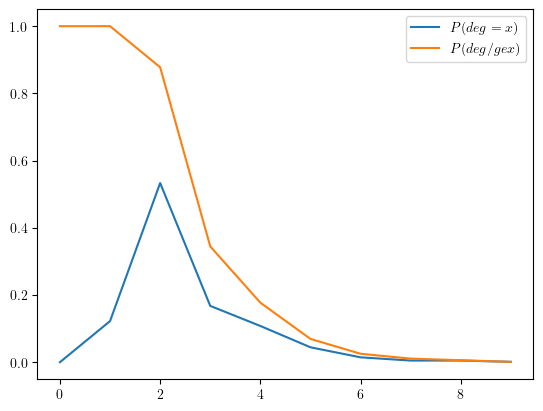

In [31]:
plt.rcParams['text.usetex']=True

# function to plot degree distribution
def plot_degree_dist(G, y_log_scale=False):
    degrees = [G.degree(n) for n in G.nodes()]
    normalize_count=len(degrees)
    values, base = np.histogram(degrees, range(np.max(degrees)+1))
    cumulative = np.flip(np.cumsum(np.flip(values/normalize_count)))
    plt.plot(base[:-1], values/normalize_count, label='$P(deg=x)$')
    plt.plot(base[:-1], cumulative, label='$P(deg/ge x)$')
    if y_log_scale:
        plt.yscale('log')
    plt.legend()
    plt.show()

# plotting degree distribution
plot_degree_dist(G)

In [32]:
# minimum, mean and maximum degrees
df_res.describe().T.iloc[1:2][['min', 'mean', 'max']]

,min,mean,max
degrees,1.0,2.512031,10.0


Most nodes in the network have a degree of two and the average degree is 2.5, while there are no nodes with less than one connection and no nodes with more than ten connections.

A node with a degree of two or two connections to it is most likely a highway access point, a node with four connections is most likely a intersection of two highways.

### Degree Assortativity

In [33]:
# calculating assortativity for G
nx.degree_pearson_correlation_coefficient(G)

0.0900398138005564

In [34]:
# calculating assortativity for R
test_property_on_random_graph(
    G,
    lambda R: nx.degree_pearson_correlation_coefficient(R))

-0.14948136333922846 10


-0.014948136333922845

Pearson Correlation Coefficient
- G:  0.0900
- R: -0.0149

Assortativity in a network refers to the tendency of nodes to connect with other ‘similar’ nodes over ‘dissimilar’ nodes.

The degree assortativity of *G* is low but positive (G is slightly assortative), while degree assortativity of *R* is low but negative (R is slightly disassortative).

Both *G* and *R* have Pearson Correlation Coefficient close to zero, so there is no clear correlation between degree of a given node and degrees of the nodes it is connected to. This means in regard to assortivity the graph *G* show no exceptional behaviour.

Though technically, nodes in *G* have a slight tendency to connect to a node with a similar number of degrees, while the nodes in *R* are unlikely to be connected with nodes that have a similar number of degrees.

This is most likely explained by the logical fashion of how the routes are planned and highways are built, connecting nearby cities of similar size and importance. The same behaviour is absent in randomly generated graphs.

## Conclusion EDA

The road network graph *G* and random graph *R* have been compared across several measures and the results indicate that *G* differs significantly from *R* in the following ways:

- *G* has a diameter that is 4 times larger than that of *R*
- *G* has an average shortest path length that is 2.5 times larger than that of *R*
- *G* has a transitivity that is 15 times larger than that of *R*
- *G* has an average local clustering coefficient that is 10 times larger than that of *R*

These findings suggest that *G* is less densely connected and may have more isolated areas than *R*. However, for definitive conclusions, further investigation is required.

### The Friendship Paradox

The friendship paradox describes the phenomenon that on average most people have fewer friends than their friends have.

Studies of the facebook network have shown that 87% of people in the network have fewer friends than their friends have on average.

We shall investigate how this translates to a road network.

In [35]:
# mean degree
G.size() * 2 / G.order()

2.512030798845043

In [36]:
# mean neighbor degree average
sum(nx.average_neighbor_degree(G).values()) / G.order()

3.033563637196939

In [37]:
# degrees of all nodes
degrees = np.array(G.degree())[:, -1]

# average neighborhood degree
neighbor_degree_avg = np.array(list(nx.average_neighbor_degree(G).items()))[:, -1]

sum(degrees<neighbor_degree_avg)/G.order()*100

57.65158806544755

The comparison of the percentage of nodes with fewer connections than the nodes they are connected to in a road network and a social network shows a significant difference. The road network has a percentage of 57% while the social network has a percentage of 87%.

This can be attributed to the two dimensional structure of a road network which does not allow for direct connections between distant nodes. This reduces the chance that a given node in the road network will have fewer connections than the nodes it is connected to and thus the friendship paradox is less likely to be observed in a road network.

## Link Prediction
### On nodes' names

In [38]:
# splitting graph, edges and labels into test graph
edgeSplitter=EdgeSplitter(G)
graph_test, samples_test, labels_test=edgeSplitter.train_test_split(p=0.1, method='global', seed=1)

** Sampled 130 positive and 130 negative edges. **


In [39]:
# splitting test graph, edges and labels into training graph
edgeSplitter=EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train=edgeSplitter.train_test_split(p=0.1, method='global', seed=1)

** Sampled 117 positive and 117 negative edges. **


In [40]:
# configuring classifier
clf = RandomForestClassifier(random_state=1, n_jobs=-1)

In [41]:
# fitting classifier on names
clf.fit(samples_train, labels_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [42]:
# making predictions
y_test_pred = clf.predict(samples_test)

In [43]:
# instantiating empty dataframe
results = pd.DataFrame()

# function to add results to a dataframe
def add_eval(results, algorithm, y_test, y_test_pred):
    results= pd.concat([results, pd.DataFrame([{
        "algorithm": algorithm, 
        "precision": precision_score(labels_test, y_test_pred),
        "f1_score": f1_score(labels_test, y_test_pred),
        "recall": recall_score(labels_test, y_test_pred)}])], ignore_index=True)
    return results

In [44]:
# adding results
results = add_eval(results, "RF_names", labels_test, y_test_pred)

# printing results
results

,algorithm,precision,f1_score,recall
0,RF_names,0.70339,0.669355,0.638462


Testing the prediction of missing links in the graph based on the node names, yields precision of 70%.

This is propably due to the sequential naming of nodes, which means nodes in a similar numeric range have a good chance of being connected.

This can be tested by randomizing the node names, to see if the precision score of the prediction drops.

### Link prediction on randomly named nodes

In [45]:
# list of node ids
node_ids = np.arange(1, len(G))

# list with new node ids randomize
rand_node_ids = np.arange(1, len(G))
random.Random(1).shuffle(rand_node_ids)

# to convert lists to dictionary
mapping = {node_ids[i]: rand_node_ids[i] for i in range(len(node_ids))}

# relabeling nodes, renaming graph H
G_renamed = nx.relabel_nodes(G, mapping)

In [46]:
# splitting graph, edges and labels into test graph
edgeSplitter=EdgeSplitter(G_renamed)
graph_test, samples_test, labels_test=edgeSplitter.train_test_split(p=0.1, method='global', seed=1)

** Sampled 130 positive and 130 negative edges. **


In [47]:
# splitting test graph, edges and labels into training graph
edgeSplitter=EdgeSplitter(graph_test, G_renamed)
graph_train, samples_train, labels_train=edgeSplitter.train_test_split(p=0.1, method='global', seed=1)

** Sampled 117 positive and 117 negative edges. **


In [48]:
# training the classifier on random names
clf.fit(samples_train, labels_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [49]:
# making prediction
y_test_pred = clf.predict(samples_test)

In [50]:
# adding results to table
results = add_eval(results, "RF_rand_names", labels_test, y_test_pred)

# printing results table
results

,algorithm,precision,f1_score,recall
0,RF_names,0.703390,0.669355,0.638462
1,RF_rand_names,0.533898,0.508065,0.484615


When train the classifier on a graph where the node IDs have randomized the precision drops from 70% to 51%, which suggests the classifier only learned the naming scheme of the nodes in this case, we conclude that names of the nodes provide information to which nodes they are connected to.

### Using edges of nodes and randomize node IDs

We can also use the Node2Vec model to vectorize the graph, then embed the edges using a Hadamard transform and use these a training data for the classifier.

In [51]:
# training Node2Vec model
model = Node2Vec(
    graph_train,
    workers=16,
    seed=1).fit()

Computing transition probabilities:   0%|          | 0/1039 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]1 [00:00<?, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 5): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]


In [52]:
# learning embeddings
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [53]:
# array of training embeddings
train_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_train]

In [54]:
# training classifier on edge embeddings
clf.fit(train_embeddings, labels_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [55]:
# array of test embeddings
test_embeddings = [edges_embs[str(x[0]), str(x[1])] for x in samples_test]

In [56]:
# making predictions
y_test_pred = clf.predict(test_embeddings)

In [57]:
# adding results to table
results = add_eval(results, "RFC_edges", labels_test, y_test_pred)

In [58]:
# displaying results sorted by F1 score
results.sort_values('precision', ascending=False)

,algorithm,precision,f1_score,recall
2,RFC_edges,0.766355,0.691983,0.630769
0,RF_names,0.703390,0.669355,0.638462
1,RF_rand_names,0.533898,0.508065,0.484615


## Conclusion Link Prediction

The dataset provided is not able to accurately predict the construction of new roads between specific nodes in the network. Analysis of the node names yielded an accuracy of 70%, however this decreased to 53% when the node names were randomized. This suggests that the node names contain some indication of their geographic location and, by extension, the location of neighboring nodes.

In contrast, utilizing edge embeddings, which take into account the overall structure of the graph, improved the accuracy of predictions by 1% to a total of 71%. To further increase the precision of predictions, additional information such as geographic location and the type of connection (national highway, federal road, etc.) would be beneficial.

## Community Discovery
### Networkx Louvain Community Detection Algorithm

In [59]:
# calculating louvain communities
louvain_comms = nxc.louvain_communities(G, seed=1)

# printing number of communities found
len(louvain_comms)

21

In [60]:
# making a list of community subgraphs
list_sub_graphs = []
for community in louvain_comms:
    H = G.subgraph(community)
    list_sub_graphs.append(H)

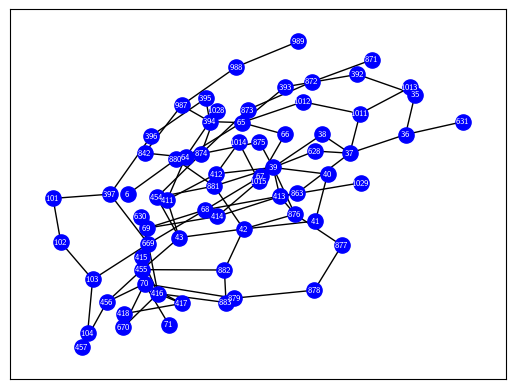

In [61]:
# displaying first subgraph 
nx.draw_networkx(list_sub_graphs[0], pos=pos, font_size=6, node_size=120, node_color='blue', font_color='white')

Above is an example plot of the first subgraph. Since the graph layout does not correspond to geography and there are no city names for the nodes, we will not plot the other subgraphs.

We are however able to calculate the node with the highest relative closeness centrality for each community.

In [62]:
# function to calculate centralities
def calculate_centralities(subgraph):
    # empty dataframe for results
    df = pd.DataFrame()

    # making list of nodes
    nodes = []
    for node in subgraph.degree:
        nodes.append(node[0])
    df['node'] = nodes

    # dict of stength per node
    degrees = {}
    for node, strength in subgraph.degree:
        degrees[node] = strength
    
    # adding degrees to dataframe
    df_degrees = pd.DataFrame(degrees, index=[0]).T
    df_degrees = df_degrees.reset_index()

    df = pd.concat([df, df_degrees], axis=1)

    df.columns = ['node', 'index', 'degrees']

    df = df.drop(['index'], axis=1)

    # closeness
    closeness_cent = nx.closeness_centrality(subgraph)

    df_closeness = pd.DataFrame(closeness_cent, index=[0]).T

    df_closeness = df_closeness.reset_index()
    df_closeness = df_closeness.drop(['index'], axis=1)

    df = pd.concat([df, df_closeness], axis=1)
    df.columns = ['node', 'degrees', 'closeness_cent']
    
    # calculating relative measures
    df['degrees_r'] = df.degrees / len(subgraph)
    df['closeness_cent_r'] = df.closeness_cent / len(subgraph)

    # reordering dataframe
    df.columns = [
        'node', 'degrees', 'degrees_r', 'closeness_cent', 'closeness_cent_r']
    res = df.sort_values('closeness_cent_r', ascending=False).head(1)[['node', 'closeness_cent_r']]
    return res

In [63]:
# calculating nodes with highest relative closeness centrality
dfs_list = []
for subgraph in list_sub_graphs:
    dfs_list.append(calculate_centralities(subgraph))
central_nodes = pd.concat(dfs_list, axis=0, ignore_index=True)

# printing node with highest relative closeness centrality for each community
central_nodes[['node']]

,node
0,39
1,86
2,674
3,137
4,211
5,270
6,7
7,792
8,304
9,711


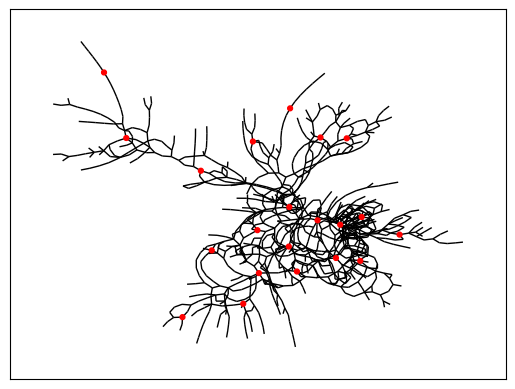

In [64]:
highlight_nodes = central_nodes.node.to_list()

colors = ['red' if node_name in highlight_nodes else 'blue' for node_name in list(G.nodes)]
size = [12 if node_name in highlight_nodes else 0 for node_name in list(G.nodes)]
nx.draw_networkx(G, pos, font_size=4, node_size=size, node_color=colors, with_labels=False)
plt.show()

The plot above illustrates the nodes with the highest closeness centrality among the 21 communities identified by the networkx Louvain community detection module.

### Python Louvain Community Detection Algorithm
### Visualizing Communities

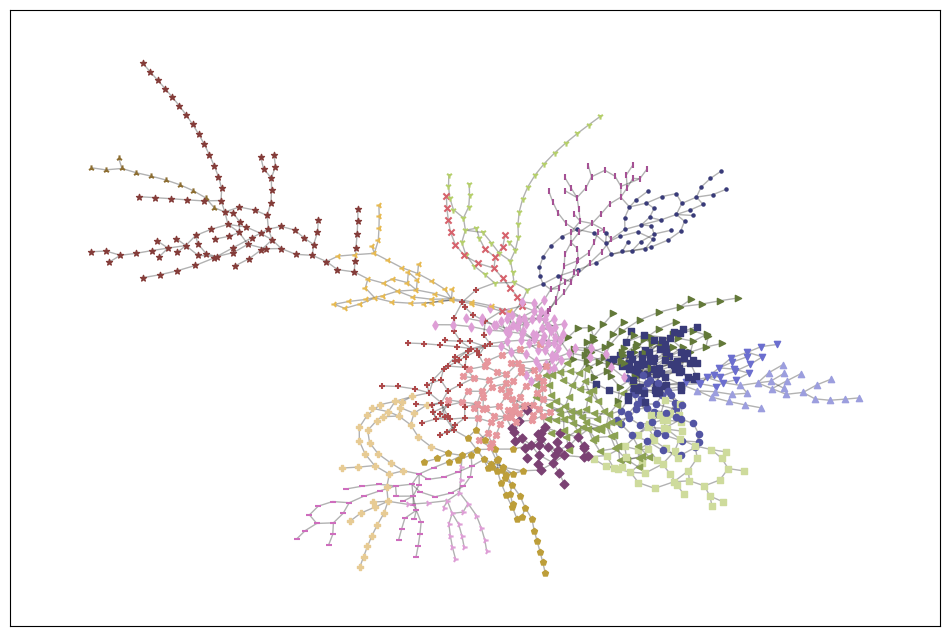

In [65]:
# sourced from: https://python-louvain.readthedocs.io/en/latest/api.html
# compute the best partition
partition = community_louvain.best_partition(G, random_state=1)

# configuring color map and shapes
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
shapes = '.,ov^><1s2p3P*+xXD|_d4h8'

# setting plot size
plt.figure(figsize=(12,8))

# color the nodes according to their partition
cmap = cm.get_cmap('tab20b', max(partition.values()) + 1)
nx.draw_networkx_edges(G, pos, alpha=.3)
for node, color in partition.items():
    nx.draw_networkx_nodes(G, pos, [node], node_size=20,
                           node_color=[cmap.colors[color]],
                           node_shape=shapes[color])

In [66]:
# printing number of communities
len(set(val for dict in [partition] for val in dict.values()))

22

In [67]:
# extracting keys with the same values
l_communities = {
    value: [key for key in partition if partition[key] == value] 
    for value in set(partition.values())}

# making a list of list with node labels per community
l_communities = [*l_communities.values()]

In [68]:
# making a list of community subgraphs
list_sub_graphs = []
for community in l_communities:
    H = G.subgraph(community)
    list_sub_graphs.append(H)

In [69]:
# calculating nodes with highest relative closeness centrality
dfs_list = []
for subgraph in list_sub_graphs:
    dfs_list.append(calculate_centralities(subgraph))
central_nodes = pd.concat(dfs_list, axis=0, ignore_index=True)

# printing node with highest relative closeness centrality for each community
central_nodes[['node']]

,node
0,440
1,454
2,47
3,12
4,918
5,100
6,106
7,316
8,86
9,814


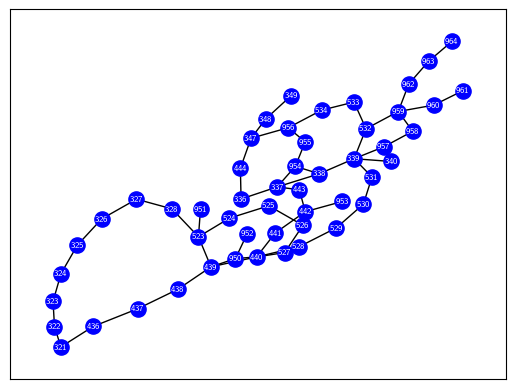

In [70]:
# displaying first subgraph 
nx.draw_networkx(
    list_sub_graphs[0],
    pos=pos, font_size=6,
    node_size=120, node_color='blue', font_color='white')

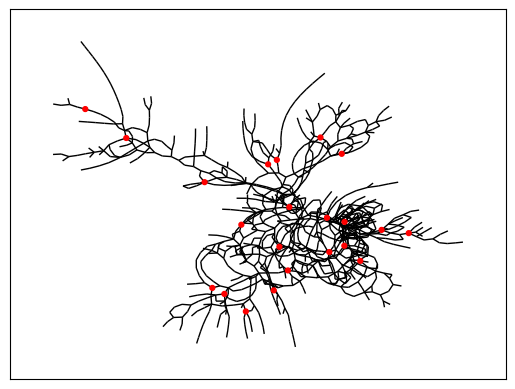

In [71]:
# plotting community centers
highlight_nodes = central_nodes.node.to_list()

colors = ['red' if node_name in highlight_nodes else 'blue' for node_name in list(G.nodes)]
size = [12 if node_name in highlight_nodes else 0 for node_name in list(G.nodes)]
nx.draw_networkx(G, pos, font_size=4, node_size=size, node_color=colors, with_labels=False)

### Conclusion Community Detection

The Louvain Community Detection algorithm was used to extract the community structure of the network based on modularity optimization. Depending on which algorithm was used, either 21 or 22 separate communities were discovered across 1039 nodes. Each community was assigned to its own subgraph and the relative closeness centrality was calculated. The nodes with the highest relative closeness centrality within each community are highlighted in red. These locations would be well-suited as logistics centers in a European fulfillment network, however, it is important to confirm that building at any of the chosen locations is actually feasible. The resolution of the algorithm can be adjusted to return more communities of smaller size, if more than 21/22 fulfillment centers are required.

It can be roughly interpreted that the 21/22 communities found correspond to countries, considering the 27 member states in the EU. However, it is worth noting that smaller countries like those of the Benelux region might have been grouped into a single region. It is also important to note that it was impossible to determine the year in which the dataset was published, thus making it impossible to draw a correlation between EU member states at the time and the 21/22 communities that were found. It is important to investigate why the two algorithms produced different results.

# Final Conclusion

The Louvain Community Detection algorithm was used to extract the community structure of the network based on modularity optimization. The algorithm helped us identify well-connected regions within the network and provided insight into the community structure of the network. However, it is important to note that when determining suitable locations for logistics centers, the calculation of the nodes with the highest closeness centrality is based on the number of edges that have to be traversed and not taking into account the varying lengths of the edges. However, to find suitable locations for logistics centers, it is important to take into account real-world distances of the edges and investigate the feasibility of constructing fulfillment centers at these locations before making any decisions.

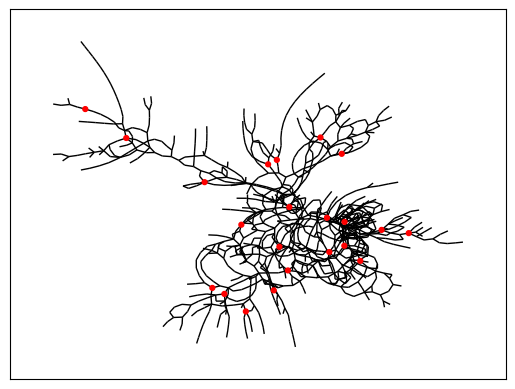

In [72]:
nx.draw_networkx(G, pos, font_size=4, node_size=size, node_color=colors, with_labels=False)

It is also worth mentioning that the average local clustering coefficient of the road network graph is 10 times higher than that of a random graph with the same properties, which implies that the roads are strongly interconnected and the network is easy to navigate and well-connected.

Additionally, the diameter of the road network graph is four times larger than that of a random graph, which suggests that the average distance between any two nodes in the road network is much greater than would be expected by chance. This could mean that the road network may be less densely connected and may have more isolated areas.

On the other hand, using edge names to predict missing links produced an accuracy of 70%, which decreased to 53% when the node names were randomized. This suggests that the node names contain some indication of their geographic location and, by extension, the location of neighboring nodes.

In [73]:
print((time.time()-start_time) / 60)

1.104920470714569
